# Klasterinė analizė: Pagrindinės sąvokos 
# *(Cluster analysis: Basic concepts)*

Klasterinė analizė priskiriama prie *("Unsupervised learning")* Mokymasis be mokytojo t.y. nėra iš anksto nustatytų klasių.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
                                import os
                                import pandas                         as pd
                                import matplotlib.pyplot              as plt
                                import numpy                          as np
                                import itertools
                                import seaborn                        as sns; sns.set()
from sklearn                    import metrics
from matplotlib.ticker          import MultipleLocator

In [3]:
# Comment this if the data visualisations doesn't work
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.color'] = '#474545'
plt.rcParams['axes.edgecolor'] = '#474545'

In [4]:
import os

__file__ = 'Clusterization.ipynb'
__path__ = os.path.dirname(os.path.realpath(__file__))

print('File path: %s' % __path__)
print('File name: %s' %__file__)

File path: /workspaces/optimisation_shortest_path/notebooks
File name: Clusterization.ipynb


Methods for clustering:
    
* [HDBSCAN](http://hdbscan.readthedocs.io/en/latest/index.html)
* DBSCAN
* BIRCH

[Worcking with dictionarys](https://stackoverflow.com/a/8381589/7347438)

## Artumo matas *(Proximity measure)*
Trumpiausio maršruto paieška yra parempa atstumais tarp taškų A ir B. tyrimo atveju tie atstumai yra laikas skirtas perreguliuoti gamybinę liniją perreinant iš vienos detalės į kitą. esant ~300 elementų viso yra (n^2)/2 (45000) perstatymo laikų. Deje nagrinėjamojoje įmonėje nėra dar identifikuoti visi perstatymo laiki o tik dals iš jų. Pasirinktas variantas naudoti skaičiavimams artumo matus tokius kaip **Euklido** **Cosine** **Manhattan** kurie gaunami iš techninių charakteristikų aprašančių kiekvieną detalę (charakteristikos įtakojančios įrenginio perreguliavimo trukmę). Iškeliamas tikslas patikrinti kuris iš artumo matų yra tinkamiausias.


In [5]:
from sklearn.metrics.pairwise   import euclidean_distances
from sklearn.metrics.pairwise   import cosine_distances
from sklearn.metrics.pairwise   import manhattan_distances

In [6]:
df = pd.read_csv('../output/mungy/data_nm.csv').set_index('ID')
df.shape

(265, 357)

In [7]:
# df_setup_time = pd.read_csv('../input/set-up matrix.csv', sep=';').\
#                 melt(id_vars='Item/Item', var_name='item', value_name='value')
# df_setup_time.columns = ['A','B','setup_time']

# from functools import reduce

# labels = df.index.values

# df_euclidean_distances = pd.DataFrame(euclidean_distances(df, df), index = labels, columns = labels).\
#                             reset_index().\
#                             melt(id_vars='index', var_name='item', value_name='value')

# df_euclidean_distances.columns = ['A','B','euclid_distance']

# df_cosine_distances = pd.DataFrame(cosine_distances(df, df), index = labels, columns = labels).\
#                             reset_index().\
#                             melt(id_vars='index', var_name='item', value_name='value')

# df_cosine_distances.columns = ['A','B','cosine_distances']

# df_manhattan_distances = pd.DataFrame(manhattan_distances(df, df), index = labels, columns = labels).\
#                             reset_index().\
#                             melt(id_vars='index', var_name='item', value_name='value')

# df_manhattan_distances.columns = ['A','B','manhattan_distances']

# dfs = [df_setup_time, df_euclidean_distances, df_cosine_distances, df_manhattan_distances]
# result = reduce(lambda left,right: pd.merge(left,right,on=['A', 'B']), dfs)


## Korelecija tarp pertstaymo laikų ir nustatytais artumo matais.

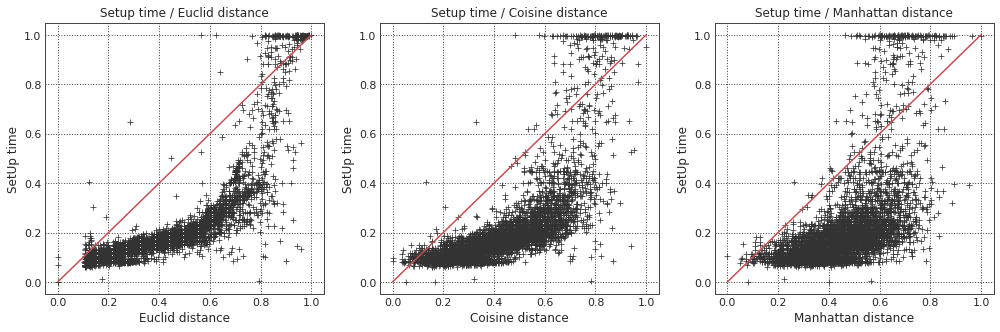

In [8]:
df_setuptime = pd.read_csv('../input/setup_time.csv')

fig, axes = plt.subplots(1,3, figsize=(17,5), sharex=True)
axes = axes.flatten();

titles = [
    'Setup time / Euclid distance',
    'Setup time / Coisine distance',
    'Setup time / Manhattan distance'
]

xy = [ 
        ('SetUp time','Euclid distance'),
        ('SetUp time','Coisine distance'),
        ('SetUp time','Manhattan distance')          
    ]

for ax, (x,y), title  in zip(axes, xy, titles): 
        sns.scatterplot(
            x=y, y=x, data=df_setuptime, 
            color=".2", marker="+", ax=ax,
            ).set_title(title)

        ax.plot([0,1], [0,1], 'r-')


Patikrinus ryšį tarp perstatymo laikų ir pasirinktų tryjų artumo matų (COISINE / MANHETEN / EUCLID) nustatyta kad mažiausia sklaida yra su Euclido matu. ryšys nėra tiesinis tad atitinkamai parenkama kreivė kuria remiantis galima būtų prognozuoti savo reikšmes. atsižvelgiant į duomenų sklaidą pertikrinamos įvairios kreivės tokios kaip logoritminė kreivė , logistinė sigmoidė ir kt.

In [9]:
from scipy.optimize import curve_fit

#callculate r squared
def r_squared(xData, yData):
    correlation_matrix = np.corrcoef(xData, yData)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared


# exponential function with adidtional konstant
def func0(x,a,b,c):
    # return a/(1+(x/c)**b)
    return c+a*np.exp(b*x)

# exponential function
def func1(x, a, b):
    return a*np.exp(b*x) 

# logarithmic function
def func2(x, a,b):
  return a*np.exp(x)+b

# # generalized logistic function
def func3(x, a, b, c, d, g):
    return ((a-d)/((1+((x/c)**b))**g))+d

def func4(x, a,b,c,d):
#   return a*np.exp((x-c)/d)+b
    return a/(1 + np.exp(-c * (x - d))) + b

# parabola function
def func5(x, a,b,c):
    return a*x**2+b*x+c



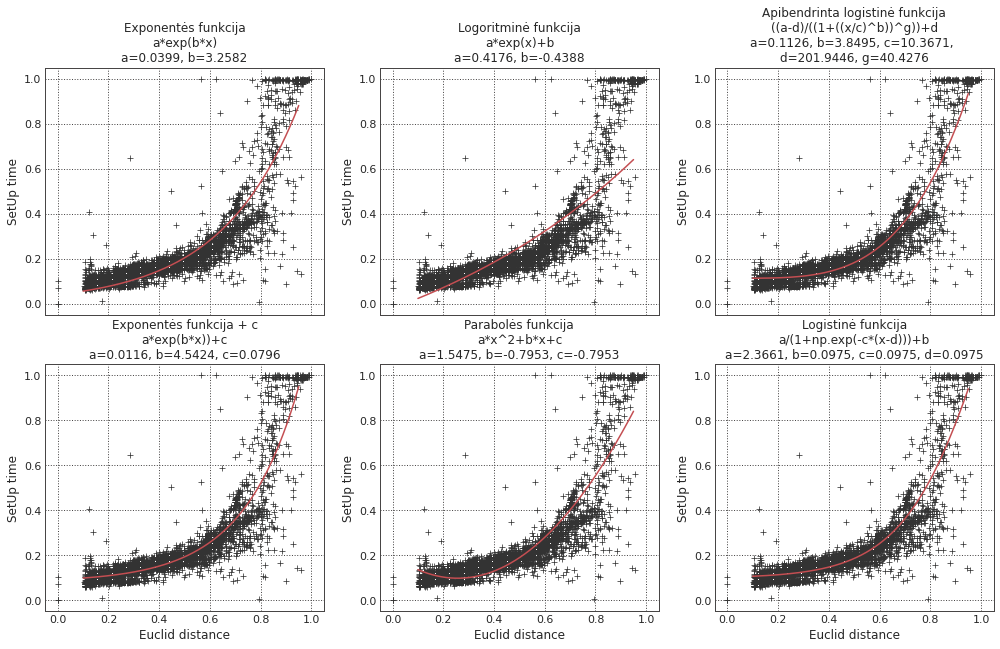

In [10]:
from scipy import stats

fig, axes = plt.subplots(2,3, figsize=(17,10), sharex=True)
axes = axes.flatten();

lsFunc = [func1, func2, func3, func0, func5, func4]

option_grid = [
    dict(method='lm'),
    dict(method='lm'),
    dict(method='lm'),
    dict(method='dogbox'),
    dict(method='lm'),
    dict(method='lm')
]

titles = [
    'Exponentės funkcija\na*exp(b*x)\na={0:5.4f}, b={1:5.4f}',
    'Logoritminė funkcija\na*exp(x)+b\na={0:5.4f}, b={1:5.4f}',
    'Apibendrinta logistinė funkcija\n((a-d)/((1+((x/c)^b))^g))+d\na={0:5.4f}, b={1:5.4f}, c={2:5.4f}, \nd={3:5.4f}, g={4:5.4f}',
    'Exponentės funkcija + c\na*exp(b*x))+c\na={0:5.4f}, b={1:5.4f}, c={2:5.4f}',
    'Parabolės funkcija\na*x^2+b*x+c\na={0:5.4f}, b={1:5.4f}, c={1:5.4f}',
    'Logistinė funkcija\na/(1+np.exp(-c*(x-d)))+b\na={0:5.4f}, b={1:5.4f}, c={1:5.4f}, d={1:5.4f}'
]

fit_metrics_results = {
    'Function':[],
    'Slope':[], 
    'Intercept':[], 
    'R value':[], 
    'R-squared':[], 
    'p value':[], 
    'Standart err':[]
}

x = np.linspace(0.1, 0.95, 5096)
xData = df_setuptime['Euclid distance']
yData = df_setuptime['SetUp time']

for ax, title, func, options  in zip(axes, titles, lsFunc, option_grid): 

        popt, pcov = curve_fit(func, xData, yData, **options)

        slope, intercept, r_value, p_value, std_err = stats.linregress(xData,pd.Series(func(x, *popt)))

        fit_metrics_results['Function'].append(title.format(*popt))
        fit_metrics_results['Slope'].append(slope)
        fit_metrics_results['Intercept'].append(intercept)
        fit_metrics_results['R value'].append(r_value)
        fit_metrics_results['R-squared'].append(r_value**2)
        fit_metrics_results['p value'].append(p_value)
        fit_metrics_results['Standart err'].append(std_err)

        sns.scatterplot(
            x=xData, y=yData, data=df_setuptime, 
            color=".2", marker="+", ax=ax,
            ).set_title(title.format(*popt))

        ax.plot(x, func(x, *popt),  'r-', label="Fitted Curve")

Remiantis rezultatais nustatome kad geriausiai atitinkanti kreivė yra apibendrinta logistinė funkcija, tai atsispindi tiek grafike tiek atsižvelgiant į R^2 rodiklį

In [11]:
pd.DataFrame(fit_metrics_results)

Function     Slope  Intercept  \
0  Exponentės funkcija\na*exp(b*x)\na=0.0399, b=3... -0.023185   0.308086   
1  Logoritminė funkcija\na*exp(x)+b\na=0.4176, b=...  0.001869   0.287761   
2  Apibendrinta logistinė funkcija\n((a-d)/((1+((... -0.035920   0.317451   
3  Exponentės funkcija + c\na*exp(b*x))+c\na=0.01... -0.031565   0.313645   
4  Parabolės funkcija\na*x^2+b*x+c\na=1.5475, b=-... -0.041043   0.318805   
5  Logistinė funkcija\na/(1+np.exp(-c*(x-d)))+b\n... -0.033307   0.316789   

    R value  R-squared   p value  Standart err  
0 -0.022480   0.000505  0.108594      0.014447  
1  0.002301   0.000005  0.869559      0.011380  
2 -0.034719   0.001205  0.013190      0.014487  
3 -0.031015   0.000962  0.026827      0.014253  
4 -0.040759   0.001661  0.003613      0.014097  
5 -0.032061   0.001028  0.022095      0.014548

## Klasterizavimo metodai *(Clusterisation algorithms)*


Toliau Rializuojami Klasterizavimo metodai:
 - K-MEANS
 - Hierarchical Clustering ('ward','complete','average','single')
 - DBSCAN
 - HDBSCAN
 - BIRCH

In [12]:
def split_grid(parameter_grid):
    """Input: {x:[y]}, Output: [{x:y}]"""
    return [list_of_toople_to_dic([*zip(parameter_grid.keys(), values)]) 
            for values 
            in [*itertools.product(*parameter_grid.values())]]        
        
def list_of_toople_to_dic(values):
    """Input: [(x,y)], Output: {x:y}"""
    return {key:value for key, value in values}

def add_metrics(model, values, dic):
    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    dic['Clusters'].append(n_clusters_)
    # dic['Noise points'].append(n_noise_)
    dic['Silhouette Coefficient'].append(metrics.silhouette_score(df.values, labels)\
        if n_clusters_ != 0 else -1)
    dic['Min. cluster size'].append(min([count_matching(label, labels) for label in np.unique(labels)]))
    dic['Max. cluster size'].append(max([count_matching(label, labels) for label in np.unique(labels)]))


    return dic

def count_matching(condition, seq):
    """Returns the amount of items in seq that return true from condition"""
    return sum(1 for item in seq if condition == item)

clust_results = {
        'Method' : [],
        'Model': [],
        'Min. cluster size' : [],
        'Max. cluster size' : [],
        'Clusters' : [],
        # 'Noise points' : [],
        'Silhouette Coefficient' : []
}

### K-Means

In [13]:
from sklearn.cluster import KMeans

parameter_grid = dict(
    n_clusters = np.round(np.arange(10, 31, 1), decimals=0), 
)

options_grid = split_grid(parameter_grid)

for options in options_grid:

    model = KMeans(random_state = 0, **options).fit(df.values)
    labels = model.labels_

    clust_results['Method'].append('KMeans')
    clust_results['Model'].append(options)

    clust_results = add_metrics(model, df.values, clust_results)

### Hierarchical Clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering

parameter_grid = dict(
    n_clusters = np.round(np.arange(10, 31, 1), decimals=0), 
    linkage=['ward','complete','average','single']
)

options_grid = split_grid(parameter_grid)

for options in options_grid:

    model = AgglomerativeClustering(**options).fit(df.values)
    labels = model.labels_

    clust_results['Method'].append('Hierarchical - {}'.format(options.get('linkage')))
    clust_results['Model'].append(options)

    clust_results = add_metrics(model, df.values, clust_results)

### DBSCAN

In [15]:
# Compute DBSCAN
from sklearn.cluster            import DBSCAN

parameter_grid = dict(
    eps=np.round(np.arange(0.1, 7, 0.1), decimals=1)
    # min_samples = np.round(np.arange(1, 10, 1), decimals=0)
)

options_grid = split_grid(parameter_grid)

for options in options_grid:

    model = DBSCAN(n_jobs=-1, **options, min_samples = 5).fit(df.values)
    labels = model.labels_

    clust_results['Method'].append('DBSCAN')
    clust_results['Model'].append(options)

    clust_results = add_metrics(model, df.values, clust_results)

### HDBSCAN

HDBSCAN - theese method contane several steps:

    1. Transform the space according to the density/sparsity.
    2. Build the minimum spanning tree of the distance weighted graph.
    3. Construct a cluster hierarchy of connected components.
    4. Condense the cluster hierarchy based on minimum cluster size.
    5. Extract the stable clusters from the condensed tree.

In [16]:
import hdbscan

parameter_grid = dict(
    # min_cluster_size = getattr(np.round(np.arange(5, 20, 1, dtype=int), decimals=0), "tolist", lambda: value)()
)

options_grid = split_grid(parameter_grid)

for options in options_grid:

    model = hdbscan.HDBSCAN(gen_min_span_tree=True, **options, min_cluster_size=5).fit(df.values)

    clust_results['Method'].append('HDBSCAN')
    clust_results['Model'].append(options)

    clust_results = add_metrics(model, df.values, clust_results)

### BIRCH

In [17]:
from sklearn.cluster            import Birch

parameter_grid = dict(
    n_clusters = getattr(np.round(np.arange(10, 31, 1, dtype=int), decimals=0), "tolist", lambda: value)(),
)

options_grid = split_grid(parameter_grid)

for options in options_grid:

    model = Birch(**options).fit(df.values)

    clust_results['Method'].append('BIRCH')
    clust_results['Model'].append(options)
    
    clust_results = add_metrics(model, df.values, clust_results) 

Atlikus visus klasterizavimo metodus rezultatai pateikiami grrafike.

    1. pateikiamas bendras vaizdas visų klasterizavimo rezultatų
    2. pateikiamas vaizdas klasterizavimo rezultatų nustatytos imties. imtis parenkama atsižvelgiant į įvairius kriterijus
        2.1. neperdidelė imtis įvairių klasterių, nes tai blogina rezultatus pagrindinio tikslo gauti optimalias sekas klasterio viduje ir tarp klasterių.
        2.2. nepermažas klasterių kiekis nes tada visos detalės bus susitelkusios keliose klasteriuose ir 

[(0.58, 0.74)]

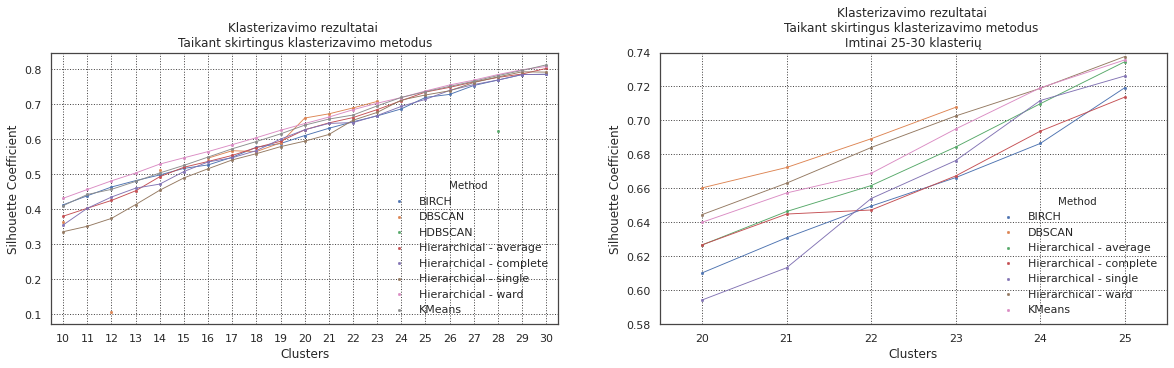

In [23]:
clust_results_agg = clust_results\
                .groupby(['Method', 'Clusters'], sort=True, as_index=False)\
                .agg({'Silhouette Coefficient':'max'})

sns.set(rc={"lines.linewidth": 0.5})
sns.set_style("whitegrid",
    {
        'grid.linestyle':':',
        'grid.color':'#474545',
        'axes.edgecolor':'#474545'
    })

fig, axes = plt.subplots(1,2, figsize=(20,5))
axes = axes.flatten()
 
sns.pointplot(data=clust_results_agg[clust_results_agg['Clusters']>=10], x='Clusters', y='Silhouette Coefficient', hue='Method', ax=axes[0])
axes[0].set(title="Klasterizavimo rezultatai \nTaikant skirtingus klasterizavimo metodus")
axes[0].xaxis.grid(True)

sns.pointplot(data=clust_results_agg[(clust_results_agg['Clusters']>=20) & (clust_results_agg['Clusters']<=25)], x='Clusters', y='Silhouette Coefficient', hue='Method', ax=axes[1])
axes[1].set(title="Klasterizavimo rezultatai \nTaikant skirtingus klasterizavimo metodus \nImtinai 25-30 klasterių")
axes[1].xaxis.grid(True)
axes[1].set(ylim=(0.58, 0.74))
# sns.plt.xlim(0, 12) # AttributeError: module 'seaborn' has no attribute 'plt' , palette=['black','red','black','black','black','black','black','black']
# ax.set_xlim=(0, 12) # does nothing
#ax.set(xlim=(13, 22))


Pateikiami daliniai rezultatai 10 geriausiu pozicijų remiantis **Silueto koeficientu** 

In [25]:
clust_results = pd.DataFrame(clust_results)
clust_results.to_csv('../output/metrics/{}.csv'.format('clust_results'))
clust_results.sort_values(by='Silhouette Coefficient',ascending=False).head(10)


Method                                      Model  \
20                    KMeans                         {'n_clusters': 30}   
101      Hierarchical - ward      {'n_clusters': 30, 'linkage': 'ward'}   
103   Hierarchical - average   {'n_clusters': 30, 'linkage': 'average'}   
97       Hierarchical - ward      {'n_clusters': 29, 'linkage': 'ward'}   
19                    KMeans                         {'n_clusters': 29}   
100    Hierarchical - single    {'n_clusters': 29, 'linkage': 'single'}   
104    Hierarchical - single    {'n_clusters': 30, 'linkage': 'single'}   
99    Hierarchical - average   {'n_clusters': 29, 'linkage': 'average'}   
195                    BIRCH                         {'n_clusters': 30}   
102  Hierarchical - complete  {'n_clusters': 30, 'linkage': 'complete'}   

     Min. cluster size  Max. cluster size  Clusters  Silhouette Coefficient  
20                   4                 40        30                0.812279  
101                  2                 40        30                0.807682  
103                  2                 40        30                0.802107  
97                   2                 40        29                0.798327  
19                   4                 40        29                0.796306  
100                  2                 40        29                0.792351  
104                  1                 40        30                0.791512  
99                   2                 40        29                0.786134  
195                  1                 40        30                0.785295  
102                  1                 40        30                0.785295

Remiantis šeis rezultatais matome kad skaldant duomenų imtį į daugiau klasterių dauguma klasterizavimo metodų nesusidoroja su keliama užduotimi ir skaldo imtį į klasterius kuriuos sudaro tik vienas elementas. Kas keliamam uždavinyje nėra naudinga. tokiu atveju atrenkami klasterizavimo rezultatai tik tie kurie tenkina tam tikrus reikalavimus:
Minimalus klusterio dydis >= 5. Matome kad tokiu atveju visais atvejais geriausi rezultatai stebimi su taikant **DBSCAN** klasterizavimo metodą.

In [26]:
clust_results[clust_results['Min. cluster size']>=5].sort_values(by='Silhouette Coefficient',ascending=False).head(10)

Method         Model  Min. cluster size  Max. cluster size  Clusters  \
152  DBSCAN  {'eps': 4.8}                  5                 40        23   
151  DBSCAN  {'eps': 4.7}                  5                 40        23   
155  DBSCAN  {'eps': 5.1}                  5                 40        23   
154  DBSCAN  {'eps': 5.0}                  5                 40        23   
153  DBSCAN  {'eps': 4.9}                  5                 40        23   
150  DBSCAN  {'eps': 4.6}                  5                 41        23   
148  DBSCAN  {'eps': 4.4}                  5                 43        23   
149  DBSCAN  {'eps': 4.5}                  5                 43        23   
144  DBSCAN  {'eps': 4.0}                  5                 47        23   
141  DBSCAN  {'eps': 3.7}                  5                 47        23   

     Silhouette Coefficient  
152                0.707756  
151                0.707756  
155                0.707756  
154                0.707756  
153                0.707756  
150                0.704994  
148                0.703912  
149                0.703912  
144                0.696738  
141                0.696738

Atsižvelgiant į šiuos rezultatus, toliau nagrinėsime ir stengsimės pagerinti rezultatus klasterizavimo metodo **DBSCAN** kad rasti optimalę epsilon reikšmę. 

## Sisteminis eps vertės nustatymo metodas
Kadangi eps skaičius yra proporcingas numatomam aptiktų kaimynų skaičiui, galime pasitelkti artimiausių kaimynų metodą, kad pasiektume teisingą eps įvertinimą. Atliekant artimiausio kaimyno paskaičiavimus, taškas nuo kuriuo skaičiuojame atstumą skičiuojamas kaip pirmasis taškas "Kaimynas". Tad imtis = n+1. Atrinkus ir surūšiavus atstumus jie atvaizduojami grafiškai, kur akivaizdžiai matomos bent dvi alkūnės maždaug tarp 0,5 ir 1 ir taip pat 3,1 ir 3,6. Kad nustatyti tikslų alkūnės tašką taikome **KneeLocator** metodą alkūnės taško aptikimas Ville Satopaa ir kt. 2011 m. pristatė pristatė darbą *“Finding a **“Kneedle”** in a Haystack: Detecting Knee Points in System Behavior”* tolimesneme tyrime naudosime šią metodologija nustatyti alkūnės tašką. Skaičiavimai atliekami taikant kelis skirtingus jautrumo lygius vėliau gretinant klasterizavimo rezultatus su rialiu poreikiu.

Dokumentacija Kneed https://pypi.org/project/kneed/

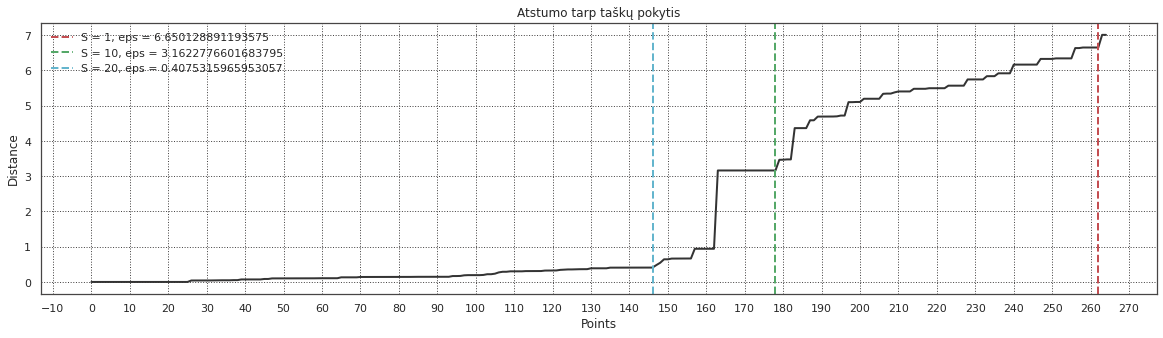

In [28]:
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import MultipleLocator
from kneed import KneeLocator

nearest_neighbors = NearestNeighbors(n_neighbors=6)
neighbors = nearest_neighbors.fit(df.values)
distances, indices = neighbors.kneighbors(df.values)
distances = np.sort(distances[:,5], axis=0)


sns.set(rc={"lines.linewidth": 2})
sns.set_style("whitegrid",
    {
        'grid.linestyle':':',
        'grid.color':'#474545',
        'axes.edgecolor':'#474545'
    })\
    

sensitivity = [1, 10, 20]
knees = []
knees_dist = []
i = np.arange(len(distances))

for s in sensitivity: 
    knee = KneeLocator(i, distances, S=s, curve='convex', direction='increasing', interp_method='interp1d')
    knees.append(knee.knee)
    knees_dist.append(distances[knee.knee])

fig,ax = plt.subplots(figsize=(20,5))
ax.xaxis.set_major_locator(MultipleLocator(10))


ax = sns.lineplot(data=distances, color='.2')\
    .set(xlabel='Points', ylabel='Distance', title='Atstumo tarp taškų pokytis')

colors = ['r', 'g', 'c']

for k, c, s, kd in zip(knees, colors, sensitivity, knees_dist):
    plt.axvline(k, color=c, linestyle='--', label=f'S = {s}, eps = {kd}');
plt.legend()



In [31]:
# Compute DBSCAN
from sklearn.cluster            import DBSCAN

options_grid = [
    {'eps':knees_dist[0]},
    {'eps':knees_dist[1]},
    {'eps':knees_dist[2]}
]

clust_results_v1 = {
        'Method' : [],
        'Model': [],
        'Min. cluster size' : [],
        'Max. cluster size' : [],
        'Clusters' : [],
        'Silhouette Coefficient' : []
}


for options in options_grid:

    model = DBSCAN(n_jobs=-1, **options, min_samples = 5).fit(df.values)
    labels = model.labels_

    clust_results_v1['Method'].append('DBSCAN')
    clust_results_v1['Model'].append(options)

    clust_results_v1 = add_metrics(model, df.values, clust_results_v1)

In [ ]:
Remiantis gautais rezultatais pasirenkamas variantas su eps=3.16227 grindžiant aukštu Silueto koeficientu ir optimaliu maximalaus klasterio dydziu.

In [33]:
pd.DataFrame(clust_results_v1)

Method                        Model  Min. cluster size  Max. cluster size  \
0  DBSCAN   {'eps': 6.650128891193575}                  2                189   
1  DBSCAN  {'eps': 3.1622776601683795}                  5                 51   
2  DBSCAN  {'eps': 0.4075315965953057}                  5                 97   

   Clusters  Silhouette Coefficient  
0         4                0.216328  
1        24                0.694729  
2        18                0.506965

## Rezultatų interpretavimas *(Interpretation of the results)*

## Metrics & Plotting

# Otput:

In [ ]:
# import subprocess

# command = f'jupyter nbconvert Exploratory_analysis.ipynb --output Exploratory_analysis.html'
# subprocess.call(command)

from IPython.display import Javascript
from nbconvert import HTMLExporter
from IPython.display import Javascript

def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)